In [1]:
base_dir = './'
data_dir = './data/'

In [2]:
import os
import warnings

import torch
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

---

In [3]:
# Data period
start_date = '2002-01-01'
end_date = '2022-12-31'

# Data source : Yahoo Finance (True), BIS (False)
from_yfinance = False

# Constant values
drop_AED = True    # UAE
drop_USD = True    # USA

# Use the maximum "connected" period only (True), or not (False)
use_consecutive_only = True

# Data config
T = 5               # dimension in time
time_lag = 1
use_target = False
target_period = 1

# Data split ratio
train_valid_ratio = .8  # ratio for train & validation data in total data
valid_ratio = .2        # ratio for validation data in train_valid data

# Data filename
data_fn = 'fx_data' + f'_with_target(target_period={target_period})' * int(use_target) + '.pt'

---

# NaNs

## NaNs in Date

In [4]:
if from_yfinance:
    fx = pd.read_csv(data_dir + 'USD2FX_YF_from_2000.csv').set_index('Date')
    
    cols = list(filter(lambda t_c: t_c[:5] == 'Close', fx.columns))
    fx = fx.loc[:, cols]
    fx.columns = [t_c.split('_')[-1] for t_c in fx.columns]
else:
    fx = pd.read_csv(data_dir + 'USD2FX_BIS_daily_avg.csv').set_index('Date')
    
date_range = list(map(lambda t: t.strftime('%Y-%m-%d'), 
                      pd.date_range(start_date, fx.index[-1])))
date_range = sorted(list(set(date_range) & set(fx.index.tolist())))

fx = fx.loc[date_range]

In [5]:
if from_yfinance:
    fx_cty_list = pd.read_csv(data_dir + 'USD2FX_YF_listed_countries.csv')
else:
    fx_cty_list = pd.read_csv(data_dir + 'USD2FX_BIS_listed_countries.csv')
fx_cty_list = fx_cty_list.loc[fx_cty_list['Currency Code'].map(lambda c: c in fx.columns)]

# duplicates in columns: EUR
cols = sorted(list(set(map(lambda c: 'EUR' if 'EUR' in c else c, fx.columns.tolist()))))
fx = fx.loc[:,cols]

fx_init_shape = fx.shape
fx_init_shape

(7623, 62)

- Discard : Weekends

In [6]:
def is_weekday(date):
    return datetime(*(list(map(int, date.split('-'))))).weekday() < 5

In [7]:
fx = fx.loc[list(map(is_weekday, fx.index)), :]
print(fx.shape)

(5445, 62)


In [8]:
def gFri2eMon(g_fri):
    yyyy, mm, dd = g_fri.split('-')
    dd = int(dd) + 3
    
    if (mm == '03' and dd > 31):
        mm = '04'
        dd = '0' + str(dd-31)
    elif (mm == '04' and dd > 30):
        mm = '05'
        dd = '0' + str(dd-30)
    else:
        dd = '0'*int(dd < 10) + str(dd)
    
    return '-'.join([yyyy, mm, dd])

def is_holiday(date):
    holidays = ['01-01',  # newyear's day
                '05-01',  # worker's day
                '12-25',  # X-mas
                '12-26'   # boxing day
               ]
    
    good_fridays = ['2000-04-21', '2001-04-13', '2002-03-29', '2003-04-18', '2004-04-09',
                    '2005-03-25', '2006-04-14', '2007-04-06', '2008-03-21', '2009-04-10', 
                    '2010-04-02', '2011-04-22', '2012-04-06', '2013-03-29', '2014-04-18', 
                    '2015-04-03', '2016-03-25', '2017-04-14', '2018-03-30', '2019-04-19', 
                    '2020-04-10', '2021-04-02', '2022-04-15'
                   ]
    
    easter_mondays = [gFri2eMon(g_fri) for g_fri in good_fridays]
    
    return (date[-5:] in holidays) or (date in good_fridays + easter_mondays)

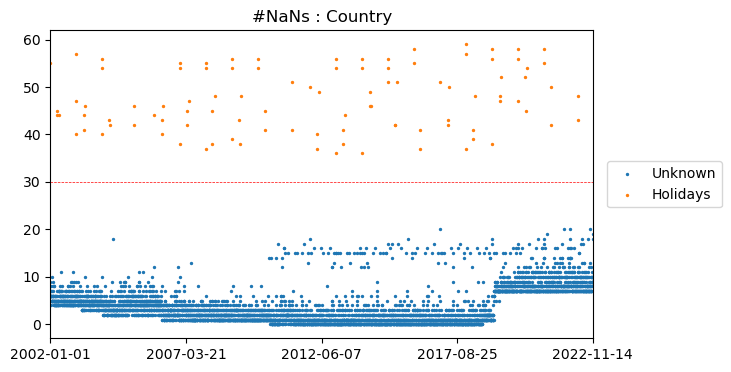

In [9]:
nan_in_date = fx.isna().sum(axis=1)
x_axis = np.arange(fx.__len__())
mask_holi = np.asarray([is_holiday(date) for date in nan_in_date.index])
t_holi = x_axis[mask_holi]
t_unk = x_axis[~mask_holi]

plt.figure(figsize=(7, 4))
plt.scatter(x=t_unk, y=nan_in_date.values[~mask_holi], s=2, label='Unknown')
plt.scatter(x=t_holi, y=nan_in_date.values[mask_holi], s=2, label='Holidays')
plt.axhline(30, c='r', linestyle='--', linewidth=0.5)
plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.25, .5))
plt.title('#NaNs : Country')
plt.xlim([0, fx.__len__()])
plt.xticks([min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)], 
           labels=fx.index[[min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)]])
plt.show()

- Discard : holidays

In [10]:
fx = fx.loc[[bool(1-is_holiday(date)) for date in fx.index], :]
fx.shape

(5346, 62)

---

## NaNs in Country

### Counts by country

In [11]:
nan_in_country = fx.iloc[::-1].isna().cumsum(axis=0).iloc[::-1]
nan_total_cty = nan_in_country.iloc[0].values

- Before cleansing

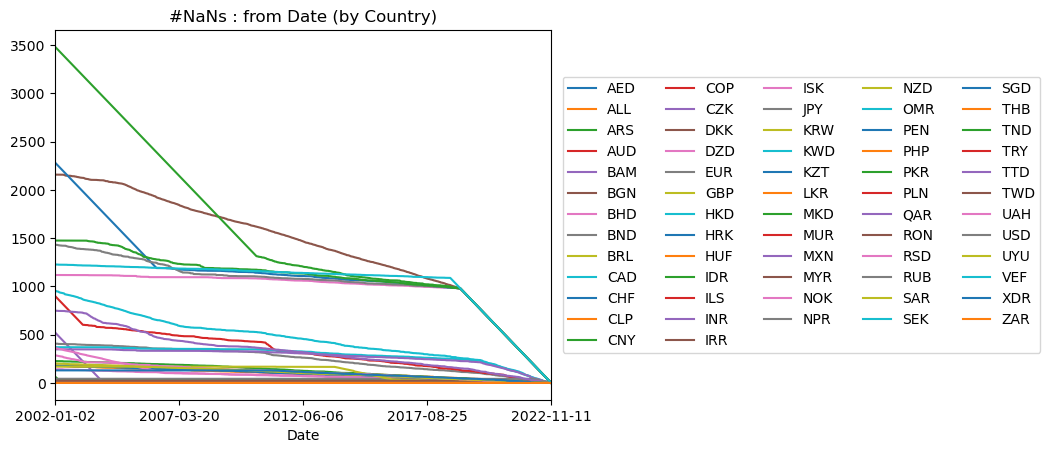

In [12]:
nan_in_country.plot(legend=False)
plt.xlim([0, fx.__len__()])
plt.xticks([min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)], 
           labels=fx.index[[min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)]])
plt.legend(loc='right', ncol=5, bbox_to_anchor=(2, .5))
plt.title('#NaNs : from Date (by Country)')
plt.show()

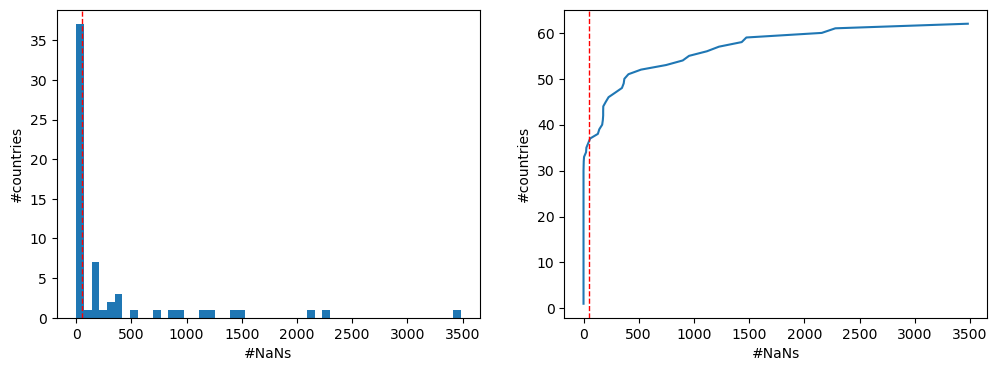

,Country,Country Code,Currency,Currency Code,num_nans
0,Albania,AL,Lek,ALL,179
1,Argentina,AR,Argentine peso,ARS,60
2,Bosnia and Herzegovina,BA,Bosnian convertible mark,BAM,521
3,Bahrain,BH,Bahraini dinar,BHD,1118
4,Brunei,BN,Brunei dollar,BND,407
5,Chile,CL,Chilean peso,CLP,175
6,Iran,IR,Iranian rial,IRR,2158
7,Iceland,IS,Icelandic krona,ISK,143
8,Kuwait,KW,Kuwaiti dinar,KWD,956
9,Kazakhstan,KZ,Tenge,KZT,2281


41.94% of currencies will be dropped


In [13]:
thres = fx.shape[0] * 0.01

cty_discarded = list(nan_in_country.columns[nan_total_cty > thres])

fx_discarded = fx_cty_list.copy()
fx_discarded['num_nans'] = 0
for i, cc in enumerate(fx_discarded['Currency Code'].values):
    fx_discarded.iloc[i, 4] = nan_total_cty[list(nan_in_country.columns).index(cc)]
    
fx_discarded = fx_discarded.loc[fx_cty_list['Currency Code'].map(lambda cc: cc in cty_discarded)].reset_index(drop=True)

# Figure
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(nan_total_cty, bins=50)
plt.xlabel('#NaNs')
plt.ylabel('#countries')
plt.axvline(thres, c='r', linestyle='--', linewidth=1)

plt.subplot(1, 2, 2)
plt.plot(sorted(nan_total_cty), np.arange(nan_total_cty.__len__())+1)
plt.xlabel('#NaNs')
plt.ylabel('#countries')
plt.axvline(thres, c='r', linestyle='--', linewidth=1)
plt.show()

# Discarded list
display(fx_discarded)

num_discard = fx_discarded['Currency Code'].unique().__len__()
prop_discard = num_discard/nan_in_country.shape[1]
print(f'{prop_discard*100:>.2f}% of currencies will be dropped')

---

- Discard : #NaNs

In [14]:
fx = fx.loc[:, sorted(list(set(fx.columns) - set(fx_discarded['Currency Code'])))]
nan_in_country = fx.iloc[::-1].isna().cumsum(axis=0).iloc[::-1]
nan_total_cty = nan_in_country.iloc[0].values
cty_keep = list(nan_in_country.columns[nan_total_cty <= thres])

fx_keep = fx_cty_list.copy()
fx_keep['num_nans'] = 0
for i, cc in enumerate(fx_keep['Currency Code'].values):
    try:
        fx_keep.iloc[i, 4] = nan_total_cty[list(nan_in_country.columns).index(cc)]
    except:
        fx_keep.iloc[i, 4] = fx.__len__()+1
    
fx_keep = fx_keep.loc[fx_cty_list['Currency Code'].map(lambda cc: cc in cty_keep)].reset_index(drop=True)
fx_NaNs = fx_keep.sort_values('num_nans', ascending=False).reset_index(drop=True)
fx_NaNs = fx_NaNs[fx_NaNs['num_nans'] > 0]

In [15]:
print('#NaNs')
for i in range(fx_NaNs.__len__()):
    if i and i % 5 == 0:
        print()
    row = fx_NaNs.iloc[i]
    print(f"{row.Country:>20s} : {row['num_nans']:>2d}", end=' ')

#NaNs
              Russia : 43 United Arab Emirates : 26       Chinese Taipei : 23             Colombia :  5              Algeria :  2 
              Israel :  1 

### Imputation

- [Optional] Discard : UAE (AED, pegged to USD since 1997)

In [16]:
excluded = []

if drop_AED:
    excluded.append('AED')
if drop_USD:
    excluded.append('USD')
    
if excluded:
    fx = fx.loc[:, sorted(list(set(fx.columns) - set(excluded)))]

- Imputation

In [17]:
if 'AED' in fx.columns:
    fx.AED = 3.6725
if 'USD' in fx.columns:
    fx.USD = 1
    
if fx.isna().sum().sum():
    from sklearn.impute import KNNImputer
    
    imputer = KNNImputer(n_neighbors=7, weights='distance')
    
    fx = pd.DataFrame(imputer.fit_transform(fx.values), 
                      columns=fx.columns, 
                      index=fx.index
                     )

---

# Scaling, Etc.

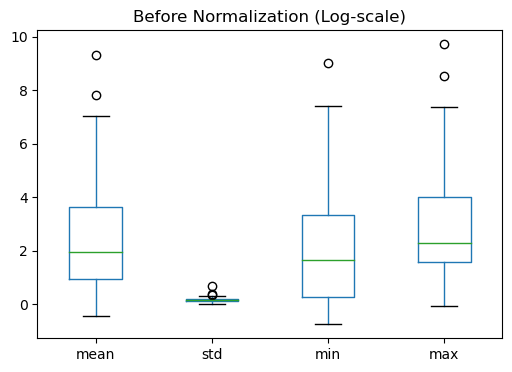

In [18]:
plt.figure(figsize=(6, 4))
fx.apply(np.log).describe().loc[['mean', 'std', 'min', 'max'], :].T.boxplot(grid=False)
plt.title(f'Before Normalization (Log-scale)')
plt.show()

## Scaling by Decimals

In [19]:
min_med_max = fx.describe().loc[['min', '50%', 'max']]
median = fx.describe().loc[['50%']]
display(min_med_max.T)

,min,50%,max
AUD,0.904683,1.311899,1.975700
BGN,1.223139,1.605788,2.274656
BRL,1.534656,2.700204,5.923369
CAD,0.907078,1.243388,1.617308
CHF,0.727431,0.993729,1.717883
CNY,6.042804,6.827057,8.370239
COP,1652.410000,2445.825000,5061.210000
CZK,14.456310,22.183170,37.075076
DKK,4.665228,6.113466,8.659128
DZD,60.240000,79.129711,147.172400


In [20]:
dec = median.applymap(lambda x: int(np.log10(x)))
fx = fx / (10 ** (dec.values+1))

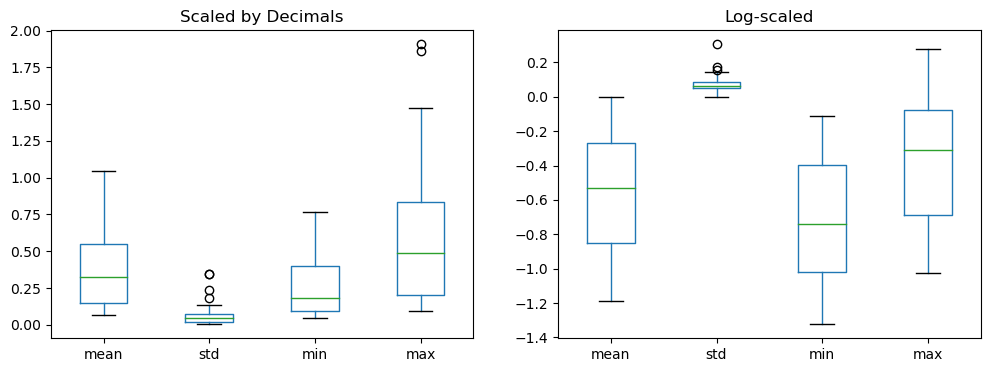

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
fx.describe().loc[['mean', 'std', 'min', 'max'], :].T.boxplot(grid=False)
plt.title(f'Scaled by Decimals')

plt.subplot(1, 2, 2)
fx.apply(np.log10).describe().loc[['mean', 'std', 'min', 'max'], :].T.boxplot(grid=False)
plt.title('Log-scaled')
plt.show()

## Window size and time lag

- Visualization before task
    - Note : "2020-02-06"

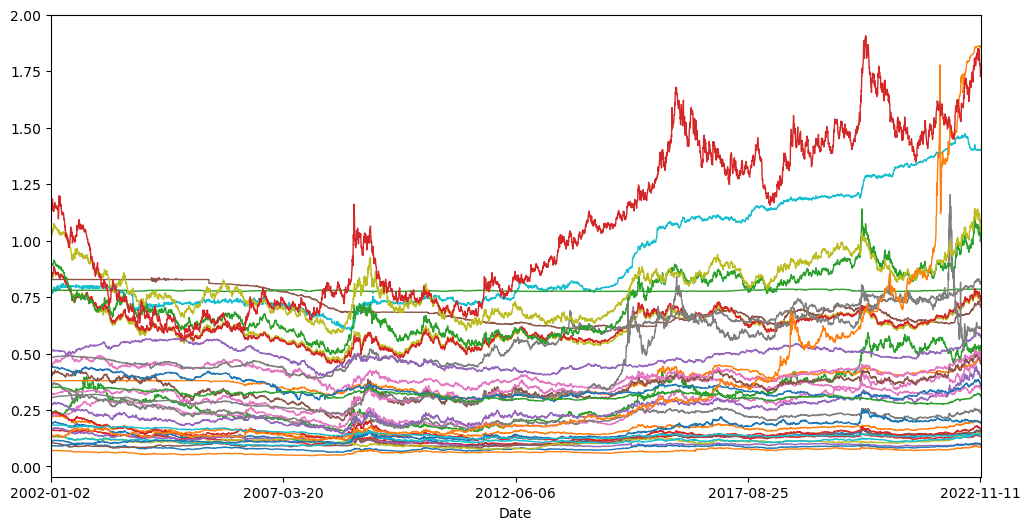

In [22]:
warnings.filterwarnings(action='ignore')

fx.plot(figsize=(12, 6), linewidth=1, legend=None)
# plt.legend([cur if cur in currencies_recently_doubled.index else '_nolegend_' for cur in fx.columns])
plt.xlim([0, fx.__len__()])
plt.xticks([min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)], 
           labels=fx.index[[min([(fx.__len__() // 4) * i, fx.shape[0]-1]) for i in range(5)]])
plt.show()

warnings.filterwarnings(action='default')

In [23]:
print(fx.shape)

(5346, 34)
